In [25]:
!pip install geopy


In [26]:
!pip install folium


In [22]:
#Imported libraries
import os
from datetime import datetime
import math
import csv

In [23]:
# The folder that contains the .gsd file
folder = folder = "C:\\Users\\kushi\\OneDrive\\Documents\\DU_Files\\data quality\\Lab 2 - DQ\\data-1\\data"

# Save to CSV
csv_path = "C:\\Users\\kushi\\OneDrive\\Documents\\DU_Files\\data quality\\Lab 2 - DQ\\kushmi_lab2.csv"


data = []
current_trip_id = None

# Function to convert coordinate
def convert_coordinate(value):
    value = float(value)
    degrees = int(value / 1000000)
    decimal_minutes = (value % 1000000) / 10000
    return degrees + (decimal_minutes / 60)

# Function to convert date & time
def convert_time(value):
    value = value.zfill(6)
    return f"{value[:2]}:{value[2:4]}:{value[4:]}"

def convert_date(value):
    value = value.zfill(6)
    return f"{value[:2]}-{value[2:4]}-20{value[4:]}"

# Function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance  # unit: km


prev_points = {}
for filename in os.listdir(folder):
    if filename.endswith('.gsd'):
        file_path = os.path.join(folder, filename)
        user = os.path.splitext(filename)[0]
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                line = line.strip()
                if line.startswith('[') and ']' in line:
                    trip_info = line.strip('[]')
                    trip_parts = trip_info.split(',')
                    if len(trip_parts) >= 1:
                        current_trip_id = trip_parts[0].strip()
                        prev_points[current_trip_id] = None  
                elif '=' in line:
                    parts = line.split('=')
                    if len(parts) > 1:
                        key = parts[0].strip()
                        values = parts[1].strip()
                        values_list = values.split(',')
                        if len(values_list) >= 6:
                            lat_original = values_list[0]
                            lon_original = values_list[1]
                            time_original = values_list[2]
                            date_original = values_list[3]
                            speed_original = values_list[4]
                            altitude = values_list[5]

                            # Here I Converted the coordinate
                            lat_converted = convert_coordinate(lat_original)
                            lon_converted = convert_coordinate(lon_original)
                            # Conversion of the time & date
                            time_str = convert_time(time_original)
                            date_str = convert_date(date_original)
                            datetime_str = date_str + ' ' + time_str
                            datetime_obj = datetime.strptime(datetime_str, '%d-%m-%Y %H:%M:%S')
                            # Conversion of the speed
                            speed_converted = float(speed_original) / 100  # km/h
                            speed_mps = speed_converted / 3.6  # Converted to m/s for later calculation
                            
                            # Distance, Time difference and Acceleration
                            distance = 0
                            time_diff = 0
                            acceleration = 0
                            prev_point = prev_points.get(current_trip_id)
                            if prev_point:
                                # Distance
                                distance = haversine(prev_point['lat'], prev_point['lon'], lat_converted, lon_converted)
                                # Time difference
                                time_diff = (datetime_obj - prev_point['datetime']).total_seconds()
                                if time_diff > 0:
                                    # Acceleration (m/s^2)
                                    acceleration = (speed_mps - prev_point['speed_mps']) / time_diff
                                else:
                                    acceleration = 0
                            else:
                                distance = 0
                                time_diff = 0
                                acceleration = 0

                            prev_points[current_trip_id] = {'lat': lat_converted, 'lon': lon_converted, 'datetime': datetime_obj, 'speed_mps': speed_mps}

                            features = [user, current_trip_id, key, lat_original, lon_original, time_str, date_str, speed_original, altitude, speed_converted,  
                                lat_converted, lon_converted, distance, time_diff, acceleration]
                            data.append(features)

#  New headers in the csv file
header = ['User_ID', 'Trip_ID', 'Point_ID','Latitude', 'Longitude', 'Time', 'Date', 'Speed', 'Altitude', 'Speed_km/h', 'Latitude_WGS84', 'Longitude_WGS84', 'Distance', 'Time_Difference', 'Acceleration']

with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for data in data:
        writer.writerow(data)

print(f'Data saved to {csv_path}')

Data saved to C:\Users\kushi\OneDrive\Documents\DU_Files\data quality\Lab 2 - DQ\kushmi_lab2.csv


In [24]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt

   User_ID  Trip_ID  Point_ID  Latitude  Longitude      Time        Date  \
0  Bullis1        1         1  60292653   15246578  12:15:33  09-06-2011   
1  Bullis1        1         2  60292797   15247460  12:18:25  09-06-2011   
2  Bullis1        1         3  60292668   15248432  12:18:55  09-06-2011   
3  Bullis1        1         4  60293713   15251138  12:19:30  09-06-2011   
4  Bullis1        1         5  60294654   15253287  12:20:00  09-06-2011   

   Speed  Altitude  Speed_km/h  Latitude_WGS84  Longitude_WGS84  Distance  \
0     50        -1        0.50       60.487755        15.410963  0.000000   
1   2170        -1       21.70       60.487995        15.412433  0.084827   
2   2950        -1       29.50       60.487780        15.414053  0.091900   
3   4460        -1       44.60       60.489522        15.418563  0.313896   
4   3779        -1       37.79       60.491090        15.422145  0.262480   

   Time_Difference  Acceleration  
0              0.0      0.000000  
1         

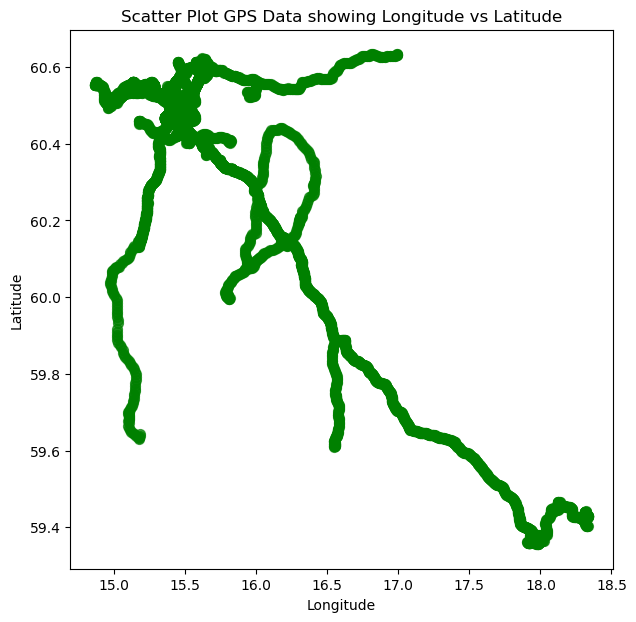

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file correctly
data = "C:\\Users\\kushi\\OneDrive\\Documents\\DU_Files\\data quality\\Lab 2 - DQ\\kushmi_lab2.csv"
df = pd.read_csv(data)  # Use read_csv for CSV files

# Check the data
print(df.head())

# Filter out rows with missing longitude or latitude
df_filtered = df.dropna(subset=['Longitude_WGS84', 'Latitude_WGS84'])

# Scatter plot showing Longitudes vs Latitudes
plt.figure(figsize=(7, 7))
plt.scatter(df_filtered['Longitude_WGS84'], df_filtered['Latitude_WGS84'], c='green', marker='o', s=50, alpha=0.7)
plt.title('Scatter Plot GPS Data showing Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


C:\Users\kushi\AppData\Local\Temp\ipykernel_24348\2571691863.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['Longitude_WGS84'], y=df['Latitude_WGS84'], cmap="Reds", shade=True, bw_adjust=.5)


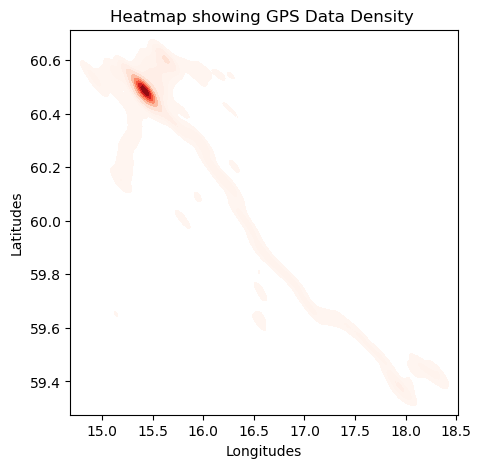

In [33]:
# Heatmap of Longitudes vs Latitudes
plt.figure(figsize=(5, 5))
sns.kdeplot(x=df['Longitude_WGS84'], y=df['Latitude_WGS84'], cmap="Reds", shade=True, bw_adjust=.5)
plt.title('Heatmap showing GPS Data Density ')
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.show()